In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy import ndimage
from datetime import datetime

In [ ]:
def set_white_color(original_cmap):
    # Get the colors from the original colormap
    colors = original_cmap(np.linspace(0, 1, original_cmap.N))
    # Set the first color to white
    colors[0, :] = [1, 1, 1, 1] #RGBA values for white
    # Create a new colormap
    new_cmap = ListedColormap(colors)
    return(new_cmap)


def array_to_xarray(array,xarray):
    """
    scipy.ndimage converts xarray to array, this function reverts it back to xarray
    """
    new_xarray = xr.DataArray(
        array,
        dims=xarray.dims,  
        coords=xarray.coords,  
        attrs=xarray.attrs,
    )
    return new_xarray

def label_clusters(data_array, structure=None):
    """
    Defines clusters in data_array and labels it. Structure can be given to change how ndimage clusters points together.
    """
    labeled_array, num_features = ndimage.label(data_array.values, structure=structure) #num_features is ignored
    labeled_xarray = array_to_xarray(labeled_array,data_array)
    return labeled_xarray

def area_weights(data_array,latitude_dim_name='latitude'):
    return np.cos(data_array[latitude_dim_name]*np.pi/180)

def filter_clusters_by_area(data_array,latitude_dim_name='latitude',AREA_THRESHOLD=500):
    ds_temp = xr.Dataset({'labels': data_array})
    ds_temp['area'] = area_weights(data_array,latitude_dim_name=latitude_dim_name)    
    label_areas= ds_temp.groupby('labels').sum() 
    labels_to_keep = label_areas.where(label_areas>AREA_THRESHOLD,drop=True)
    labels_to_keep = labels_to_keep['labels'].values
    labels_to_keep = labels_to_keep[labels_to_keep>0]
    if len(labels_to_keep) == 0:
        data_array[:] = 0
    else:
        data_array = data_array.isin(labels_to_keep).astype(int)
    return data_array

def apply_binary_morph(data_array,s=np.ones((3,3)),method='dilation'):
    """
    Apply binary structure (s) to data_array using one of the methods available ['dilation','erosion','closing','fill_holes']
    data_array and s must have the same number of dimensions
    """
    if len(data_array.shape) != len(s.shape):
        print("No morphology change: data array and structure have different shapes")
        return(data_array)
    if method not in ['dilation','erosion','closing','fill_holes']:
        print("No morphology change: methods needs to be one of ['dilation','erosion','closing','fill_holes']")
        return(data_array)
    if method=='dilation':
        binary_transformation = ndimage.binary_dilation(data_array,structure=s).astype(int)
    elif method =='erosion':
        binary_transformation = ndimage.binary_erosion(data_array,structure=s).astype(int)
    elif method == 'closing':
        binary_transformation = ndimage.binary_closing(data_array,structure=s).astype(int)
    elif method == 'fill_holes':
        binary_transformation = ndimage.binary_fill_holes(data_array,structure=s).astype(int)
    return array_to_xarray(array=binary_transformation,xarray=data_array)

In [4]:
#PARAMETERS
STDEV_THRESHOLD = -1.5
SMALL_BLOBS_FILTER = 50
AREA_THRESHOLD=1000
VARIABLE = 'anomaly_scaled'

In [5]:
ds = xr.open_dataset("temp/era5_t2min_scaled_anomalies.nc")
#ds = ds.drop_dims('season',errors='ignore')

In [6]:
ds

<xarray.Dataset> Size: 46MB
Dimensions:         (latitude: 281, longitude: 441, time: 31)
Coordinates:
  * latitude        (latitude) float32 1kB 90.0 89.75 89.5 ... 20.5 20.25 20.0
  * longitude       (longitude) float32 2kB -150.0 -149.8 ... -40.25 -40.0
  * time            (time) datetime64[ns] 248B 1970-02-07 ... 2000-02-07
Data variables:
    daily_t2_min    (time, latitude, longitude) float32 15MB ...
    anomaly         (time, latitude, longitude) float32 15MB ...
    anomaly_scaled  (time, latitude, longitude) float32 15MB ...

## Step 1: mask by stdev threshold

In [7]:
ds["mask"] = ds[VARIABLE] <= STDEV_THRESHOLD

In [42]:
ds["labeled_clusters"] = label_clusters(data_array=ds["mask"])
#ds['area'] = np.cos(ds["latitude"]*np.pi/180)

In [43]:
#ds.groupby('time').groups
ds["labeled_clusters"] =ds['mask'].groupby('time').map(label_clusters)

In [44]:
ds

<xarray.Dataset> Size: 96MB
Dimensions:           (latitude: 281, longitude: 441, time: 31)
Coordinates:
  * latitude          (latitude) float32 1kB 90.0 89.75 89.5 ... 20.5 20.25 20.0
  * longitude         (longitude) float32 2kB -150.0 -149.8 ... -40.25 -40.0
  * time              (time) datetime64[ns] 248B 1970-02-07 ... 2000-02-07
Data variables:
    daily_t2_min      (time, latitude, longitude) float32 15MB ...
    anomaly           (time, latitude, longitude) float32 15MB ...
    anomaly_scaled    (time, latitude, longitude) float32 15MB -0.1574 ... 0....
    mask              (time, latitude, longitude) bool 4MB False False ... False
    labeled_clusters  (time, latitude, longitude) int32 15MB 0 0 0 0 ... 0 0 0 0
    labeled_masked    (time, latitude, longitude) float64 31MB nan nan ... nan

## Filter smaller clusters by area

In [ ]:
filtered_ds_list = []
for t in ds.time:
    #labels_to_keep = filter_by_area(data_array=ds.sel(time=t),AREA_THRESHOLD=AREA_THRESHOLD)
    #temp_ds = ds["labeled_clusters"].sel(time=t).isin(labels_to_keep).astype(int)
    temp_ds = filter_clusters_by_area(data_array=ds["labeled_clusters"].sel(time=t),AREA_THRESHOLD=AREA_THRESHOLD)
    filtered_ds_list.append(temp_ds)

In [46]:
mask_for_labels = xr.concat(filtered_ds_list,dim='time')
ds['labeled_masked'] = ds["labeled_clusters"].where(mask_for_labels==1)

In [47]:
ds

<xarray.Dataset> Size: 96MB
Dimensions:           (latitude: 281, longitude: 441, time: 31)
Coordinates:
  * latitude          (latitude) float32 1kB 90.0 89.75 89.5 ... 20.5 20.25 20.0
  * longitude         (longitude) float32 2kB -150.0 -149.8 ... -40.25 -40.0
  * time              (time) datetime64[ns] 248B 1970-02-07 ... 2000-02-07
Data variables:
    daily_t2_min      (time, latitude, longitude) float32 15MB ...
    anomaly           (time, latitude, longitude) float32 15MB ...
    anomaly_scaled    (time, latitude, longitude) float32 15MB -0.1574 ... 0....
    mask              (time, latitude, longitude) bool 4MB False False ... False
    labeled_clusters  (time, latitude, longitude) int32 15MB 0 0 0 0 ... 0 0 0 0
    labeled_masked    (time, latitude, longitude) float64 31MB nan nan ... nan

#### Unfiltered

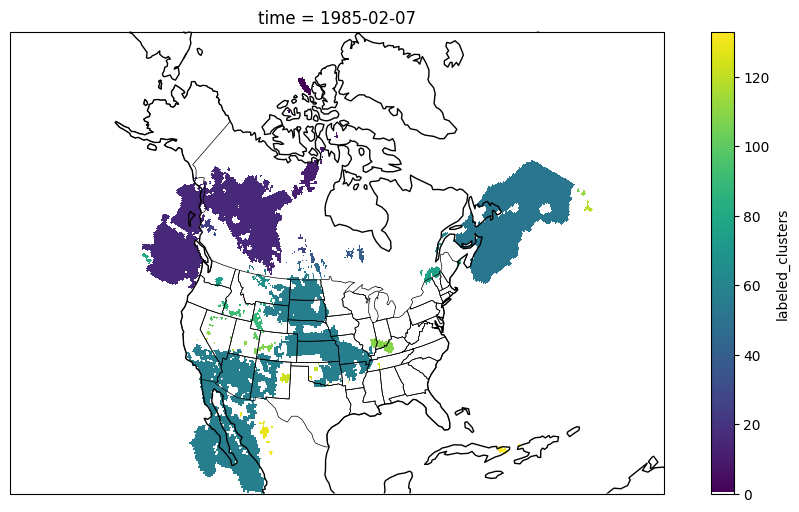

In [48]:
new_cmap = set_white_color(plt.cm.viridis)

plt.figure(figsize=(12, 6))
axes = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-100))
ds.sel(time='1985-02-07')['labeled_clusters'].plot(transform=ccrs.PlateCarree(),cmap=new_cmap)
axes.coastlines()
axes.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
axes.set_extent((-140, -50, 20, 90),ccrs.PlateCarree())
plt.show()

#### Filtered

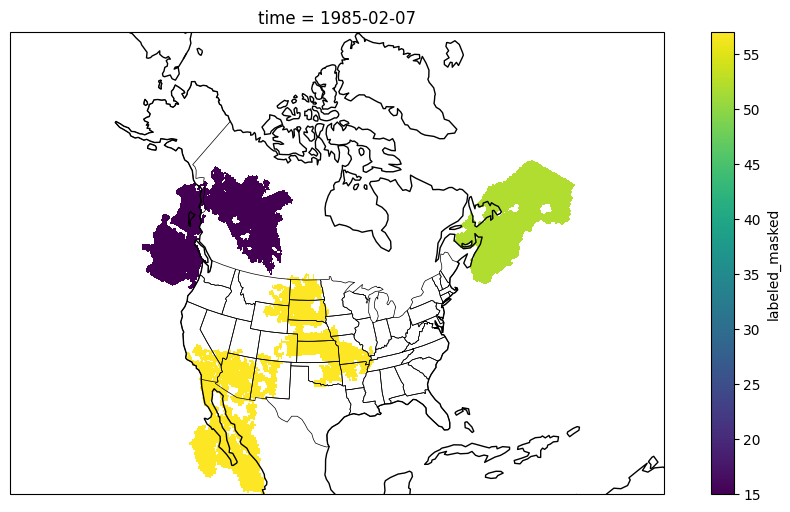

In [49]:
plt.figure(figsize=(12, 6))
axes = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-100))
ds.sel(time='1985-02-07')['labeled_masked'].plot(transform=ccrs.PlateCarree())
axes.coastlines()
axes.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
axes.set_extent((-140, -50, 20, 90),ccrs.PlateCarree())
plt.show()

In [50]:
#temp=ds[['labeled_clusters','area']].groupby(('time','labeled_clusters')).sum()
#temp['area'].to_pandas()

## Deforming clusters using binary masks

In [51]:
def apply_binary_morph(data_array,s=np.ones((3,3)),method='dilation'):
    """
    Apply binary structure (s) to data_array using one of the methods available ['dilation','erosion','closing','fill_holes']
    data_array and s must have the same number of dimensions
    """
    if len(data_array.shape) != len(s.shape):
        print("No morphology change: data array and structure have different shapes")
        return(data_array)
    if method not in ['dilation','erosion','closing','fill_holes']:
        print("No morphology change: methods needs to be one of ['dilation','erosion','closing','fill_holes']")
        return(data_array)
    if method=='dilation':
        binary_transformation = ndimage.binary_dilation(data_array,structure=s).astype(int)
    elif method =='erosion':
        binary_transformation = ndimage.binary_erosion(data_array,structure=s).astype(int)
    elif method == 'closing':
        binary_transformation = ndimage.binary_closing(data_array,structure=s).astype(int)
    elif method == 'fill_holes':
        binary_transformation = ndimage.binary_fill_holes(data_array,structure=s).astype(int)
    return array_to_xarray(array=binary_transformation,xarray=data_array)


In [52]:
new_cmap = set_white_color(plt.cm.Set1)

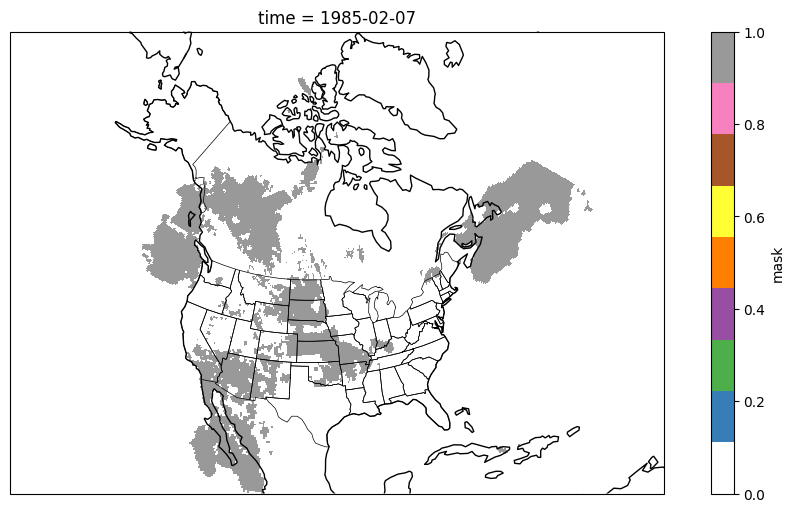

In [53]:
#Original
plt.figure(figsize=(12, 6))
axes = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-100))
ds["mask"].sel(time='1985-02-07').plot(transform=ccrs.PlateCarree(),cmap=new_cmap)
axes.coastlines()
axes.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
axes.set_extent((-140, -50, 20, 90),ccrs.PlateCarree())
plt.show()

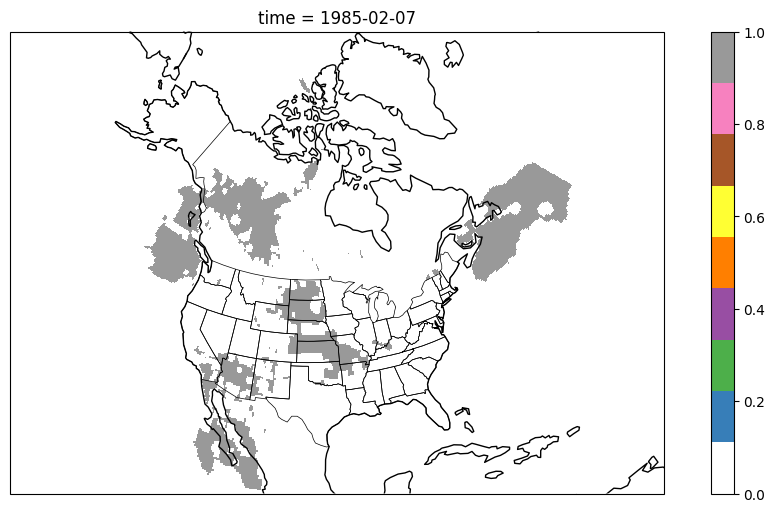

In [54]:
#Erosion
a=apply_binary_morph(ds["mask"].sel(time='1985-02-07'),method='erosion',s=np.ones((3,3)))
plt.figure(figsize=(12, 6))
axes = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-100))
a.plot(transform=ccrs.PlateCarree(),cmap=new_cmap)
axes.coastlines()
axes.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
axes.set_extent((-140, -50, 20, 90),ccrs.PlateCarree())
plt.show()

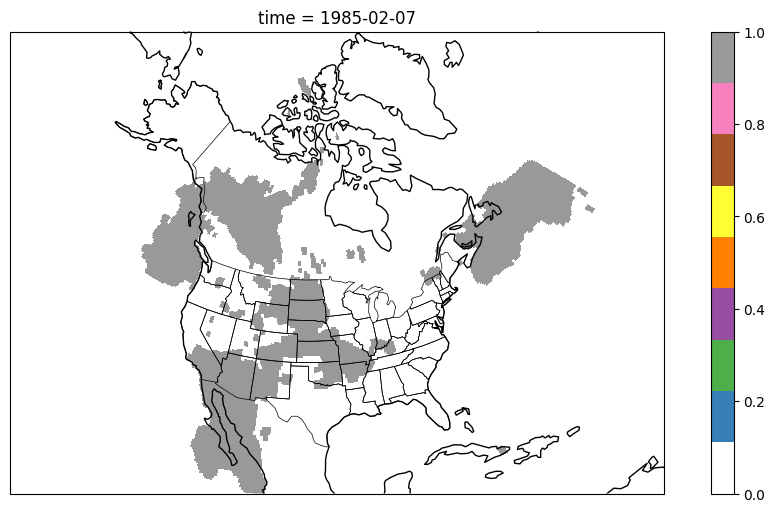

In [55]:
#Sequence of deformations
a = ds["mask"].sel(time='1985-02-07')
a=apply_binary_morph(a,method='closing',s=np.ones((3,3)))
a=apply_binary_morph(a,method='erosion',s=np.ones((2,2)))
a=apply_binary_morph(a,method='dilation',s=np.ones((3,3)))
a=apply_binary_morph(a,method='fill_holes',s=np.ones((3,3)))
plt.figure(figsize=(12, 6))
axes = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-100))
a.plot(transform=ccrs.PlateCarree(),cmap=new_cmap)
axes.coastlines()
axes.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
axes.set_extent((-140, -50, 20, 90),ccrs.PlateCarree())
plt.show()

## Area filtering

In [56]:
ds

<xarray.Dataset> Size: 96MB
Dimensions:           (latitude: 281, longitude: 441, time: 31)
Coordinates:
  * latitude          (latitude) float32 1kB 90.0 89.75 89.5 ... 20.5 20.25 20.0
  * longitude         (longitude) float32 2kB -150.0 -149.8 ... -40.25 -40.0
  * time              (time) datetime64[ns] 248B 1970-02-07 ... 2000-02-07
Data variables:
    daily_t2_min      (time, latitude, longitude) float32 15MB ...
    anomaly           (time, latitude, longitude) float32 15MB ...
    anomaly_scaled    (time, latitude, longitude) float32 15MB -0.1574 ... 0....
    mask              (time, latitude, longitude) bool 4MB False False ... False
    labeled_clusters  (time, latitude, longitude) int32 15MB 0 0 0 0 ... 0 0 0 0
    labeled_masked    (time, latitude, longitude) float64 31MB nan nan ... nan

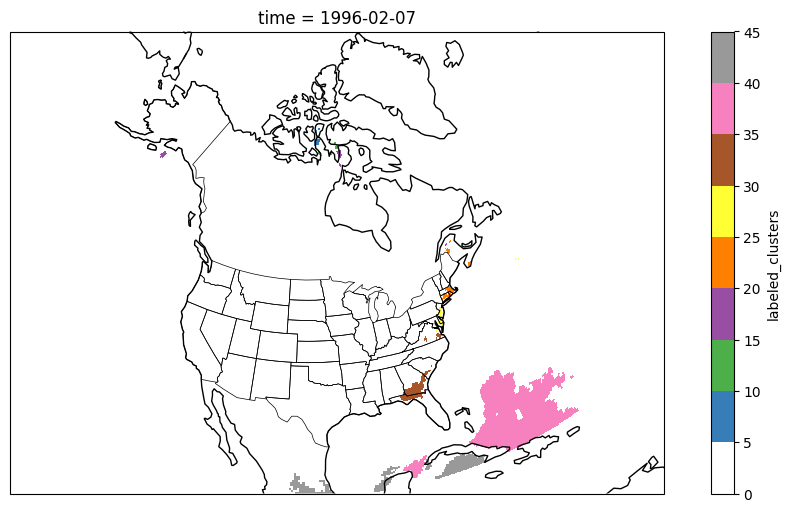

In [66]:
a = ds["labeled_clusters"].sel(time='1996-02-07')
plt.figure(figsize=(12, 6))
axes = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-100))
a.plot(transform=ccrs.PlateCarree(),cmap=new_cmap)
axes.coastlines()
axes.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
axes.set_extent((-140, -50, 20, 90),ccrs.PlateCarree())
plt.show()

c:\Users\ls2236\Projects\cao_tracker\.venv\Lib\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension labels because variable labels is not a coordinate. To create an index for labels, please first call `.set_coords('labels')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


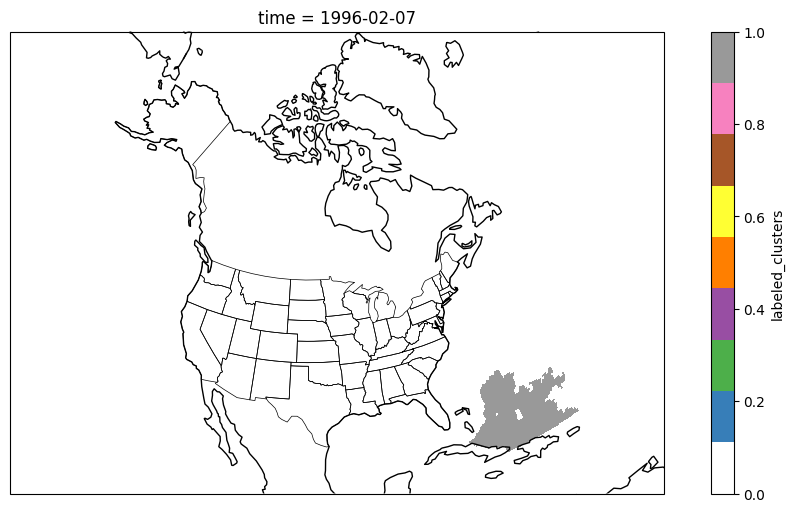

In [67]:
plt.figure(figsize=(12, 6))
axes = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-100))
filter_clusters_by_area(a).plot(transform=ccrs.PlateCarree(),cmap=new_cmap)
axes.coastlines()
axes.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
axes.set_extent((-140, -50, 20, 90),ccrs.PlateCarree())
plt.show()